In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import os
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.utils import compute_class_weight
import matplotlib.pyplot as plt
from collections import Counter
import gc
from keras import backend
import graphviz
import pydot


In [19]:
data = []
for filename in os.listdir("Cropped/UTKFace"):
    if filename.endswith(".jpg"):
        row_data = [os.path.join("Cropped/UTKFace", filename)]
        filename = filename.split("_")
        if len(filename) > 3:
            row_data.append(filename[2]) # 3rd integer represents race
            data.append(row_data)

In [20]:
df_image = pd.DataFrame(data, columns = ["filename", "Race"])

df_image = df_image[df_image["Race"] != "4"]

train, test = train_test_split(df_image, stratify = df_image["Race"], test_size=0.2)


In [21]:
df_image["Race"].value_counts(normalize=True)

Race
0    0.457820
1    0.205606
3    0.180575
2    0.155999
Name: proportion, dtype: float64

In [6]:
compute_class_weight(
    "balanced", 
    classes = np.array(["0", "1", "2", "3"]),
    y = df_image["Race"])


array([0.54606569, 1.21591913, 1.60257717, 1.38446541])

In [38]:
skf = StratifiedKFold(n_splits = 5, shuffle=True)
train_scores = []
val_scores = []
per_class_scores = []

for fold, (train_index, val_index) in enumerate(list(skf.split(X = df_image["filename"], y = df_image["Race"]))):
    backend.clear_session()
    gc.collect()


    train_df = df_image.iloc[train_index]
    validation_df = df_image.iloc[val_index]

    train = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,
                                                        fill_mode="nearest").flow_from_dataframe(
    dataframe = train_df,
    x_col = "filename",
    y_col = "Race",
    class_mode = "categorical",
    target_size = (200, 200),
        )
    test = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255).flow_from_dataframe(
    dataframe = validation_df,
    x_col = "filename",
    y_col = "Race",
    class_mode = "categorical",
    fill_mode = "nearest",
    target_size=(200, 200))

    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(200, 200, 3)))
    model.add(keras.layers.Dense(512, activation = "relu"))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(256, activation = "relu"))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(128, activation = "relu"))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(4, activation = "softmax"))
    model.compile(loss = "CategoricalCrossentropy", metrics = ["accuracy"], optimizer=keras.optimizers.Adam())
    history = model.fit(train,
            class_weight={0:0.54606569 , 1:1.21591913, 2:1.60257717, 3:1.38446541},
            validation_data = test,
            epochs = 10)

    test.reset()
    validation_predictions = np.argmax(model.predict(test), axis = -1)
    validation_true = np.array(test.classes)
    train_scores.append(history.history["accuracy"])
    val_scores.append(history.history["val_accuracy"])

    accuracy_per_class_temp = {}

    class_dict = dict(Counter(test.classes))
    for index, total in class_dict.items():
        class_predict = validation_predictions[validation_true == index]
        class_true = validation_true[validation_true == index]
        correct_predictions = np.sum(class_predict == class_true)


        percent_correct = (correct_predictions / total) * 100

        accuracy_per_class_temp[index] = percent_correct

    per_class_scores.append(accuracy_per_class_temp)
    print(per_class_scores)

    per_fold_train = np.mean(train_scores, axis = 0)
    print(per_fold_train)
    per_fold_validation = np.mean(val_scores, axis = 0)
    print(per_fold_validation)



Found 17610 validated image filenames belonging to 4 classes.
Found 4403 validated image filenames belonging to 4 classes.
Epoch 1/10
551/551 [==============================] - 16s 28ms/step - loss: 4.7593 - accuracy: 0.1899 - val_loss: 1.3865 - val_accuracy: 0.1828
Epoch 2/10
551/551 [==============================] - 14s 25ms/step - loss: 1.3929 - accuracy: 0.1948 - val_loss: 1.3893 - val_accuracy: 0.2055
Epoch 3/10
551/551 [==============================] - 14s 25ms/step - loss: 1.3871 - accuracy: 0.2232 - val_loss: 1.3873 - val_accuracy: 0.1560
Epoch 4/10
551/551 [==============================] - 14s 25ms/step - loss: 1.3865 - accuracy: 0.2354 - val_loss: 1.3904 - val_accuracy: 0.2055
Epoch 5/10
551/551 [==============================] - 14s 25ms/step - loss: 1.3867 - accuracy: 0.2418 - val_loss: 1.3900 - val_accuracy: 0.2055
Epoch 6/10
551/551 [==============================] - 14s 25ms/step - loss: 1.3867 - accuracy: 0.2170 - val_loss: 1.3888 - val_accuracy: 0.1560
Epoch 7/10
55

In [40]:
per_fold_train

array([0.20657118, 0.24249307, 0.21822316, 0.22875105, 0.24262978,
       0.27473412, 0.22638924, 0.23245339, 0.25331652, 0.21588371])

In [60]:
class_data = pd.DataFrame({"class" : per_class_scores}) 
class_data.to_csv(r"C:\Users\Allen\Desktop\Coding\CSC 466\class_scores_for_mlp.csv")

In [57]:
fold_data = pd.DataFrame({"Train": per_fold_train, "Validation": per_fold_validation}) 
fold_data.to_csv(r"C:\Users\Allen\Desktop\Coding\CSC 466\train_validation_for_mlp.csv")

In [58]:
model.save("mlp_model.keras")

In [61]:
skf = StratifiedKFold(n_splits = 5, shuffle=True)
train_scores = []
val_scores = []
per_class_scores = []

for fold, (train_index, val_index) in enumerate(list(skf.split(X = df_image["filename"], y = df_image["Race"]))):
    backend.clear_session()
    gc.collect()


    train_df = df_image.iloc[train_index]
    validation_df = df_image.iloc[val_index]

    train = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,
                                                        fill_mode="nearest").flow_from_dataframe(
    dataframe = train_df,
    x_col = "filename",
    y_col = "Race",
    class_mode = "categorical",
    target_size = (200, 200),
        )
    test = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255).flow_from_dataframe(
    dataframe = validation_df,
    x_col = "filename",
    y_col = "Race",
    class_mode = "categorical",
    fill_mode = "nearest",
    target_size=(200, 200))

    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (5, 5), padding = "same", input_shape=(200, 200, 3), activation = "relu"))
    model.add(keras.layers.Conv2D(32, (5, 5), padding = "same", activation = "relu"))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(64, (3, 3), padding = "same", activation = "relu"))
    model.add(keras.layers.Conv2D(64, (3, 3), padding = "same", activation = "relu"))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(128, (3, 3), padding = "same", activation = "relu"))
    model.add(keras.layers.Conv2D(128, (3, 3), padding = "same", activation = "relu"))
    model.add(keras.layers.MaxPool2D())
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation = "relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(4, activation = "softmax"))

    model.compile(loss = "CategoricalCrossentropy", metrics = ["accuracy"], optimizer=keras.optimizers.Adam())
    history = model.fit(train,
            validation_data = test,
            class_weight={0:0.54606569, 1:1.21591913 , 2:1.60257717, 3:1.38446541},
            batch_size = 64,
            epochs = 20)

    test.reset()
    validation_predictions = np.argmax(model.predict(test), axis = -1)
    validation_true = np.array(test.classes)
    train_scores.append(history.history["accuracy"])
    val_scores.append(history.history["val_accuracy"])

    accuracy_per_class_temp = {}

    class_dict = dict(Counter(test.classes))
    for index, total in class_dict.items():
        class_predict = validation_predictions[validation_true == index]
        class_true = validation_true[validation_true == index]
        correct_predictions = np.sum(class_predict == class_true)
        percent_correct = (correct_predictions / total) * 100

        accuracy_per_class_temp[index] = percent_correct

    per_class_scores.append(accuracy_per_class_temp)
    print(per_class_scores)

    per_fold_train = np.mean(train_scores, axis = 0)
    print(per_fold_train)
    per_fold_validation = np.mean(val_scores, axis = 0)
    print(per_fold_validation)



Found 17610 validated image filenames belonging to 4 classes.
Found 4403 validated image filenames belonging to 4 classes.
Epoch 1/20
551/551 [==============================] - 85s 153ms/step - loss: 1.6791 - accuracy: 0.3215 - val_loss: 1.3713 - val_accuracy: 0.2126
Epoch 2/20
551/551 [==============================] - 60s 109ms/step - loss: 1.2761 - accuracy: 0.2864 - val_loss: 1.3011 - val_accuracy: 0.3175
Epoch 3/20
551/551 [==============================] - 60s 109ms/step - loss: 1.1482 - accuracy: 0.3743 - val_loss: 1.0229 - val_accuracy: 0.5344
Epoch 4/20
551/551 [==============================] - 60s 109ms/step - loss: 1.0286 - accuracy: 0.4365 - val_loss: 1.0892 - val_accuracy: 0.5442
Epoch 5/20
551/551 [==============================] - 60s 109ms/step - loss: 0.9672 - accuracy: 0.4748 - val_loss: 0.8853 - val_accuracy: 0.6736
Epoch 6/20
551/551 [==============================] - 60s 109ms/step - loss: 0.8797 - accuracy: 0.5491 - val_loss: 0.8483 - val_accuracy: 0.6952
Epoch 7

In [62]:
class_data = pd.DataFrame({"class" : per_class_scores}) 
class_data.to_csv(r"C:\Users\Allen\Desktop\Coding\CSC 466\class_scores_for_cnn.csv")

In [63]:
fold_data = pd.DataFrame({"Train": per_fold_train, "Validation": per_fold_validation}) 
fold_data.to_csv(r"C:\Users\Allen\Desktop\Coding\CSC 466\train_validation_for_cnn.csv")

In [64]:
model.save("cnn_model")

INFO:tensorflow:Assets written to: cnn_model\assets


INFO:tensorflow:Assets written to: cnn_model\assets


In [ ]:
img = Image.open(
    r"C:\Users\Allen\Downloads\IMG_0791.jpg"
)

img = img.resize((200, 200))
img_array = keras.utils.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)
predicted = model.predict(img_array)
# print(np.argmax(predicted, axis = 1)[0])
print(predicted)

1/1 [==============================] - 0s 16ms/step
[[9.9998045e-01 1.5736923e-10 1.3597108e-10 1.9519108e-05]]


In [15]:
import tensorflow as tf
import keras as keras
model = tf.keras.models.load_model(r"C:\Users\Allen\Desktop\Coding\CSC 466\FacialRecognitionRacialBias\cnn_model.keras")

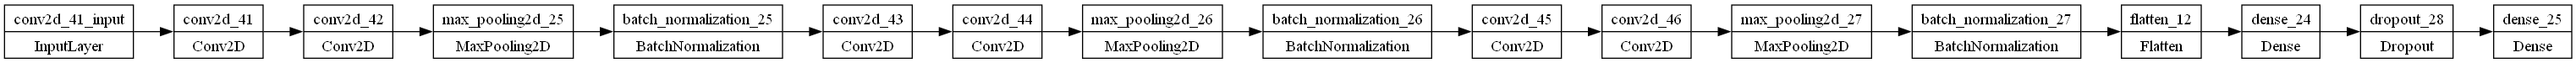

In [16]:
tf.keras.utils.plot_model(model, to_file = r"C:\Users\Allen\Desktop\Coding\CSC 466\model_cnn.png", expand_nested = True,
                          rankdir= "LR")

In [ ]:
model.save("cnn_model.keras")